Name: Harshvardhan Pandey  
Roll No: 2022112006

In [62]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import os

### Q1

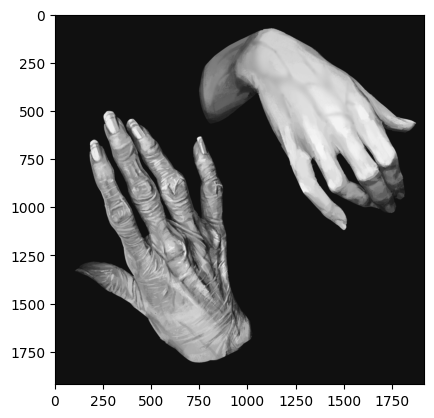

In [45]:
hand = cv2.imread("src/hands.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(hand, cmap="gray")

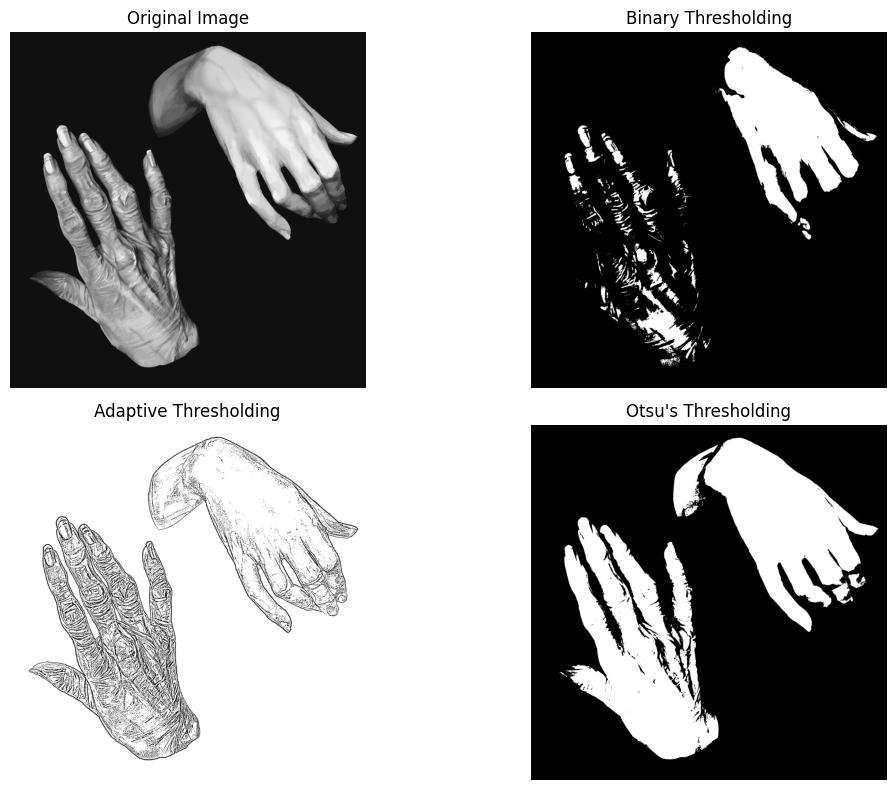

In [75]:
_, binary_thresh = cv2.threshold(hand, 127, 255, cv2.THRESH_BINARY)

adaptive_thresh = cv2.adaptiveThreshold(hand, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

_, otsu_thresh = cv2.threshold(hand, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ['Original Image', 'Binary Thresholding', 'Adaptive Thresholding', "Otsu's Thresholding"]
images = [hand, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    cv2.imwrite(f"dest/hands_{titles[i]}.png".replace(" ", "_"), images[i])
plt.tight_layout()
plt.show()

Otsu Thresholding works well when the image has a clean bimodal distribution, but adaptive distribution would work well in cases of uneven distribution.

### Q2

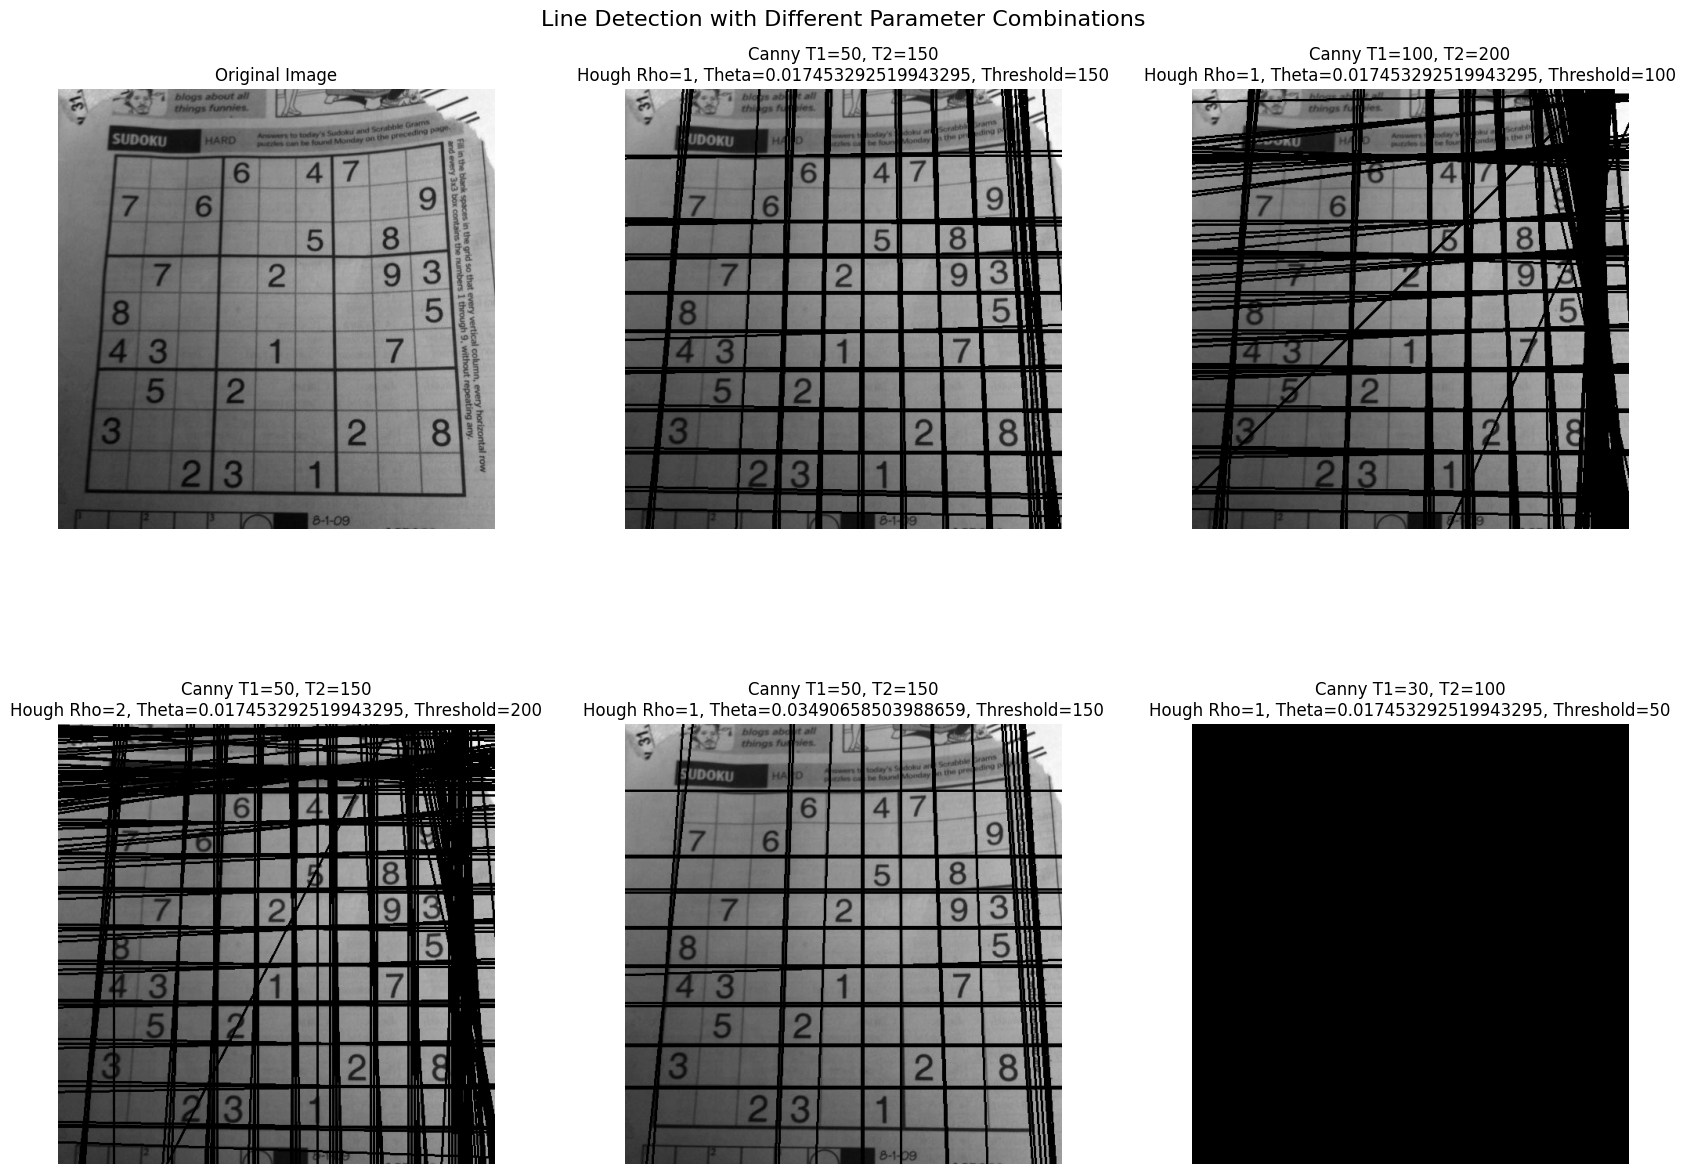

In [76]:
def detect_lines(image: np.ndarray, canny_threshold1=50, canny_threshold2=150, hough_rho=1, hough_theta=np.pi/180, hough_threshold=150) -> np.ndarray:
    # Apply Canny edge detection with adjustable thresholds
    edges = cv2.Canny(image, canny_threshold1, canny_threshold2, apertureSize=3)

    # Detect lines using Hough Line Transform with adjustable parameters
    lines = cv2.HoughLines(edges, hough_rho, hough_theta, hough_threshold)

    # Draw the lines on the original image
    output_image = image.copy()
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return output_image

# Load the image
sudoku = cv2.imread("src/sudoku.png", cv2.IMREAD_GRAYSCALE)

# Define a list of parameter combinations to experiment with
param_combinations = [
    (50, 150, 1, np.pi/180, 150),  # Default values
    (100, 200, 1, np.pi/180, 100), # Higher canny thresholds, lower hough threshold
    (50, 150, 2, np.pi/180, 200),  # Wider rho, higher hough threshold
    (50, 150, 1, np.pi/90, 150),   # Change theta for larger angles
    (30, 100, 1, np.pi/180, 50)    # Lower canny thresholds, lower hough threshold
]

# Create a figure to display the results
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.imshow(sudoku, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Iterate over each combination of parameters and display results
for i, params in enumerate(param_combinations, 1):
    canny_threshold1, canny_threshold2, hough_rho, hough_theta, hough_threshold = params
    lines_detected = detect_lines(sudoku, canny_threshold1, canny_threshold2, hough_rho, hough_theta, hough_threshold)
    file_name = f"sudoku_{canny_threshold1}_{canny_threshold2}_{hough_rho}_{hough_theta}_{hough_threshold}"
    cv2.imwrite(f"dest/{file_name}.png", lines_detected)
    
    plt.subplot(2, 3, i+1)  # Display the results in a 2x3 grid
    plt.imshow(lines_detected, cmap="gray")
    plt.title(f"Canny T1={canny_threshold1}, T2={canny_threshold2}\nHough Rho={hough_rho}, Theta={hough_theta}, Threshold={hough_threshold}")
    plt.axis("off")

plt.suptitle("Line Detection with Different Parameter Combinations", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  # Adjust spacing between subplots
plt.show()

Canny Edge Detection Threshold (canny_threshold1, canny_threshold2) controls edge sensitivity. Lower values ​​detect more edges. Including interference. while higher values ​​are less detectable and more prominent edges are visible. Hough Line transformation parameters include hough_rho, which controls the resolution of detected lines. (lower values ​​give finer accuracy) and hough_theta which adjusts the angular resolution. (Larger values ​​reduce the complexity of calculations. (But fine lines may be missed.) A lower threshold detects more noisy lines. while a higher threshold ensures that only strong lines are detected. This reduces false positives.

### Q3

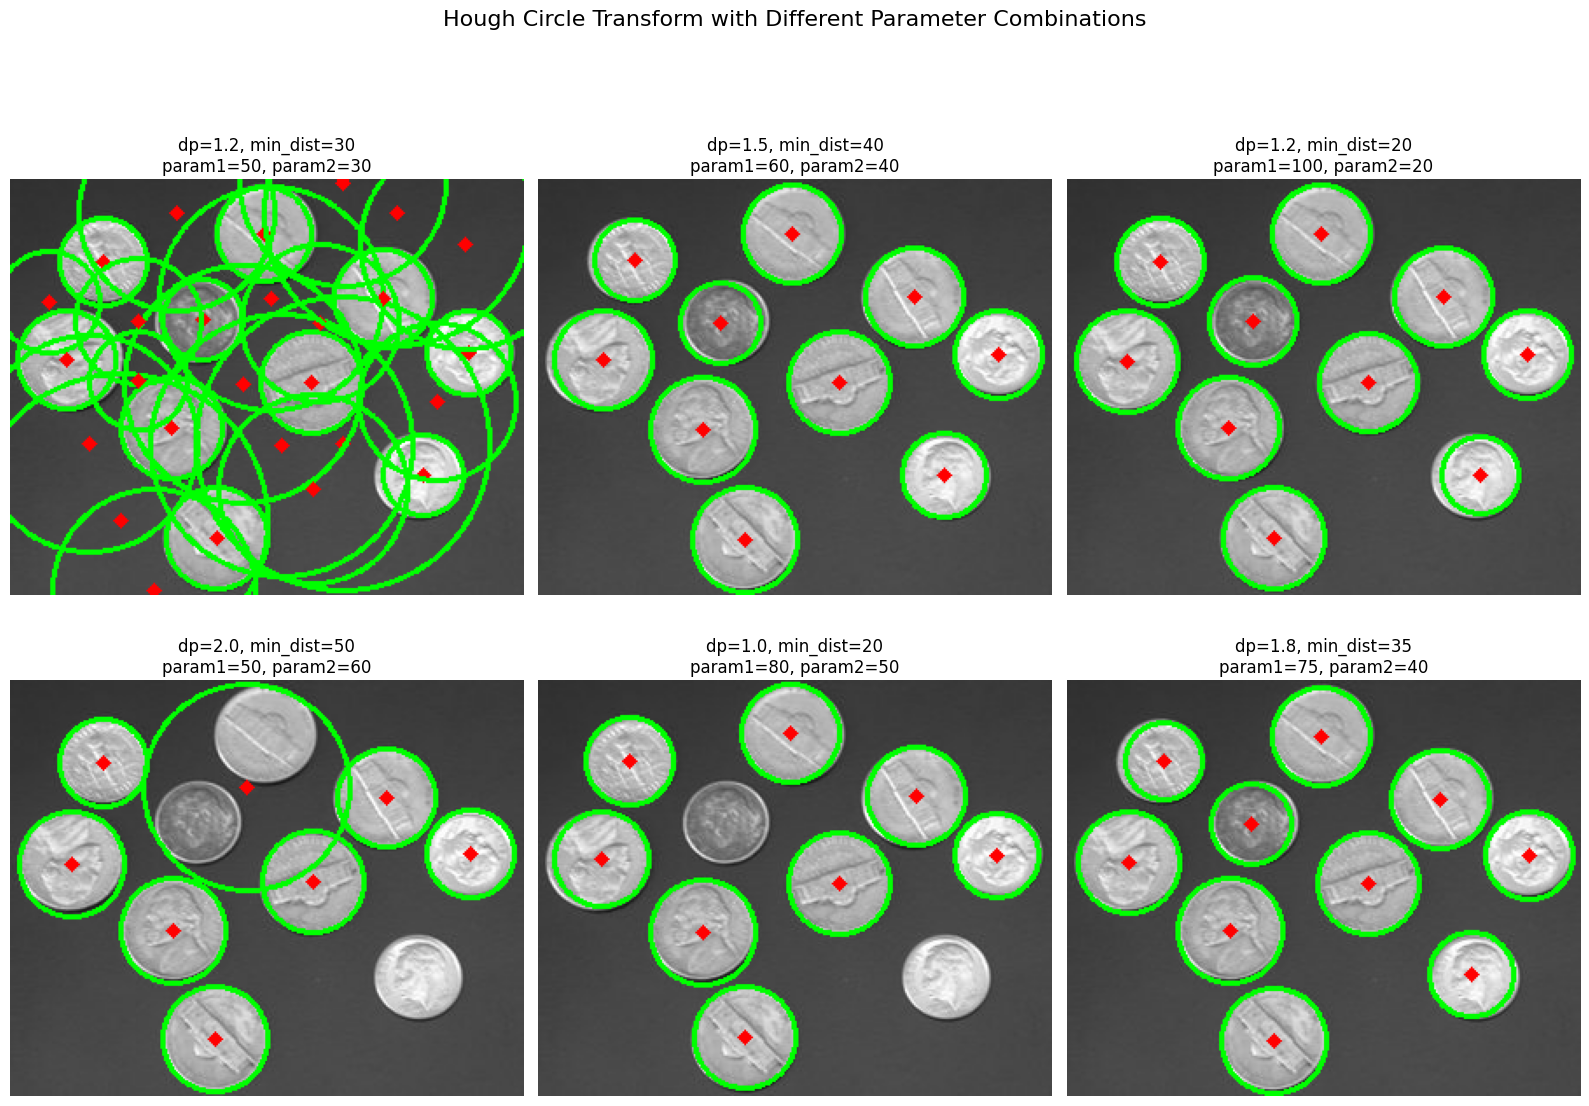

In [77]:
def detect_circles(image, dp=1.2, min_dist=30, param1=50, param2=30, min_radius=0, max_radius=0):
    """
    Detect circles in an image using the Hough Circle Transform.

    Args:
        image (np.ndarray): Grayscale image.
        dp (float): Inverse ratio of the accumulator resolution to the image resolution.
        min_dist (int): Minimum distance between detected circle centers.
        param1 (int): First parameter for the Canny edge detector (higher threshold).
        param2 (int): Threshold for center detection in Hough Transform.
        min_radius (int): Minimum circle radius.
        max_radius (int): Maximum circle radius.

    Returns:
        output_image (np.ndarray): Original image with detected circles highlighted.
        circles (np.ndarray): Detected circles, each represented as (x, y, radius).
    """

    blurred = cv2.GaussianBlur(image, (9, 9), 2)
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp,
        min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius
    )

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(output_image, center, radius, (0, 255, 0), 2)
            cv2.circle(output_image, center, 2, (0, 0, 255), 3)

    return output_image

coins = cv2.imread("src/coins.jpg", cv2.IMREAD_GRAYSCALE)

param_combinations = [
    (1.2, 30, 50, 30, 0, 0),  # Default values
    (1.5, 40, 60, 40, 20, 50),  # Adjust dp, min_dist, param1, param2, radius range
    (1.2, 20, 100, 20, 10, 30),  # Smaller min_dist, higher param1, smaller radius range
    (2.0, 50, 50, 60, 10, 60),  # Larger dp, higher min_dist and param2
    (1.0, 20, 80, 50, 5, 40),   # Lower dp, tighter radius range
    (1.8, 35, 75, 40, 15, 45)   # New test value with moderate adjustments
]

plt.figure(figsize=(16, 12))

# Iterate over each combination of parameters and display results
for i, params in enumerate(param_combinations, 1):
    dp, min_dist, param1, param2, min_radius, max_radius = params
    output_image = detect_circles(coins, dp=dp, min_dist=min_dist, param1=param1, param2=param2, min_radius=min_radius, max_radius=max_radius)
    file_name = f"coins_{dp}_{min_dist}_{param1}_{param2}_{min_radius}_{max_radius}"
    cv2.imwrite(f"dest/{file_name}.png", output_image)
    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"dp={dp}, min_dist={min_dist}\nparam1={param1}, param2={param2}")
    plt.axis("off")

# Add a title and improve spacing
plt.suptitle("Hough Circle Transform with Different Parameter Combinations", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to avoid overlap with suptitle
plt.show()

The radius range (min_radius and max_radius) controls the size of circles detected by the Hough Circle Transform. A narrow range improves accuracy but may miss circles outside the specified size. While a wider range will detect more circles it will increase false positives. The cumulative threshold (param2) determines the minimum number of points needed to consider a circle valid. Lowering this threshold will detect more circles. But it increases the risk of false positive results. while increasing it will make the detection more selective. and may disappear from weaker or louder circles. Balancing these parameters improves circle detection performance and reduces errors based on image characteristics.

### Q4

982
812
615
348


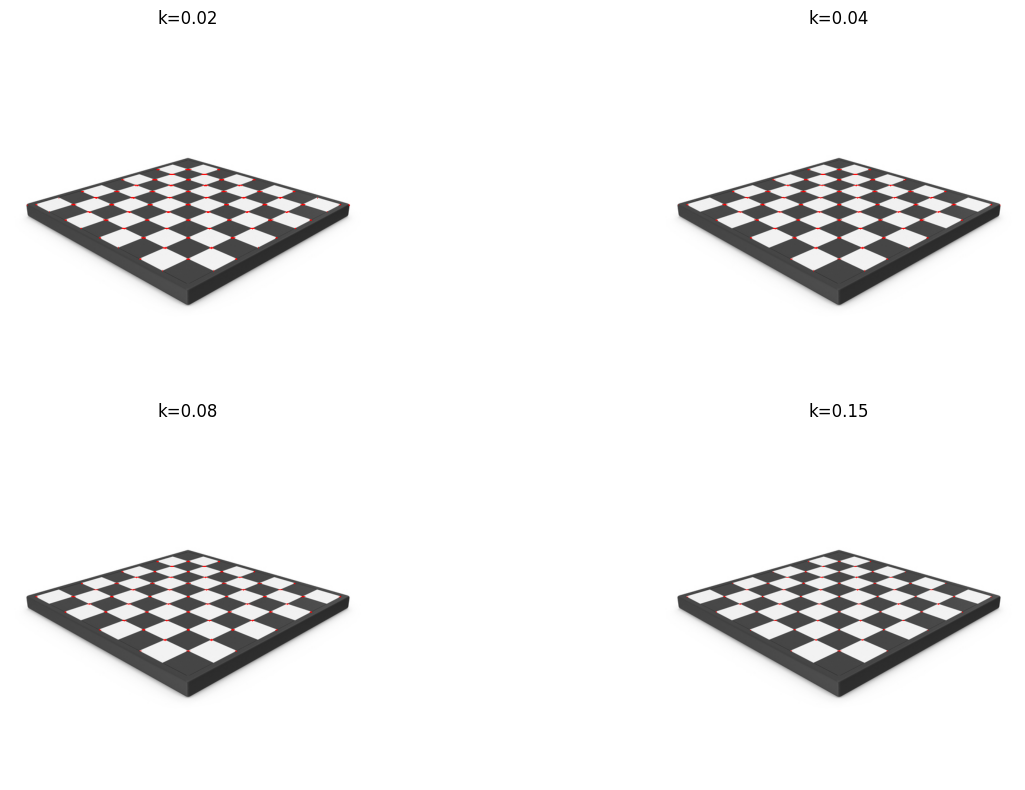

In [79]:
def harris_corner_detection(image, k=0.04, threshold=0.01):
    """
    Detect and mark corners using the Harris Corner Detection method.

    Args:
        image (np.ndarray): Grayscale image.
        k (float): Harris detector free parameter (typically between 0.04 and 0.06).
        threshold (float): Threshold to classify strong corners (proportion of max corner response).

    Returns:
        marked_image (np.ndarray): Image with corners marked.
        corners (np.ndarray): Corner response matrix.
    """
    gray = np.float32(image)
    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=k)
    print(np.sum(corners > threshold * corners.max()))
    corners_normalized = cv2.normalize(corners, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    marked_image[corners > threshold * corners.max()] = [0, 0, 255]  # Mark corners in red

    return marked_image, corners_normalized

chessboard = cv2.imread("src/chessboard.jpg", cv2.IMREAD_GRAYSCALE)

results = {
    "k=0.02": harris_corner_detection(chessboard, k=0.02)[0],
    "k=0.04": harris_corner_detection(chessboard, k=0.04)[0],
    "k=0.08": harris_corner_detection(chessboard, k=0.08)[0],
    "k=0.15": harris_corner_detection(chessboard, k=0.15)[0],
}

# Plot the results for comparison
plt.figure(figsize=(16, 8))
for i, (title, marked_image) in enumerate(results.items(), 1):
    file_name = f"chessboard_{title}"
    cv2.imwrite(f"dest/{file_name}.png", marked_image)
    plt.subplot(2, 2, i)
    plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()

A lower $k$ parameter makes the corner detection more sensitive

### Q5

The Hough Transform maps images by pointing at the parameter space and detecting lines and circles. But the visualization is significantly different. for straight lines Each point is transformed into a sinusoidal curve in \((\rho, \theta)\)-space, where \(\rho\) is the vertical distance from the origin and \(\theta\) is the angle. of lines. Circles, on the other hand, require a 3D parameter space \((x, y, r)\) to represent center and radius coordinates. This increases computational complexity because the algorithm must consider different radii in addition to the center location.

For lines, the parameter space is simpler and less computationally demanding. Make conversion more efficient Extra dimensions for circles require more storage space and processing power. This is especially true when detecting circles of uncertain sizes. This complexity can be reduced by limiting the radius range or using optimized algorithms such as the probabilistic Hough Transform. Circle detection is more computationally intensive than line detection.